# 📊 Geração de Sinal Sintético para Validação de Wavelets

## Objetivo
Este notebook gera sinais sintéticos complexos e ruidosos para validar técnicas de deep learning, especialmente as camadas de wavelets aprendidas (`LearnedWaveletDWT1D_QMF` e `LearnedWaveletPair1D_QMF`).

## Características do Sinal
O sinal gerado possui múltiplas características que são ideais para avaliar wavelets:

1. **Tendência polinomial** - Componente de baixa frequência
2. **Múltiplos harmônicos** - Componentes periódicos em diferentes frequências
3. **Chirp** - Frequência variável no tempo
4. **Mudanças de regime** - Não-estacionariedade
5. **Transientes localizados** - Eventos abruptos (wavelets são excelentes para detectar)
6. **Ruído gaussiano** - Simulação de ruído de medição
7. **Spikes aleatórios** - Outliers

## Por que este sinal é bom para wavelets?
- Wavelets são multi-escala: capturam features em diferentes frequências
- Wavelets são localizadas: detectam transientes e mudanças abruptas
- Wavelets separam sinal de ruído eficientemente

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pywt
import warnings
warnings.filterwarnings('ignore')

# Configuração de estilo
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

# Imports locais
import sys
sys.path.append('.')
from src.data_generator import SyntheticSignalGenerator, MultiScaleSyntheticGenerator
from src.visualization import ExperimentVisualizer
from src.feature_extraction import WaveletFeatureExtractor
from config.experiment_config import SYNTHETIC_SIGNAL_CONFIG, DATA_DIR

print("✅ Imports realizados com sucesso!")

ModuleNotFoundError: No module named 'numpy'

## 1. Configuração dos Parâmetros do Sinal

In [ ]:
# Parâmetros do sinal
config = {
    # Tamanho - grande para Deep Learning
    "n_samples": 50000,            # 50k amostras
    "sequence_length": 256,        # Comprimento de cada sequência
    
    # Componentes do sinal
    "trend_degree": 3,             # Polinômio cúbico
    "n_harmonics": 6,              # 6 harmônicos
    "base_frequency": 0.008,       # Frequência base baixa
    
    # Ruído - nível significativo para wavelets ajudarem
    "noise_level": 0.35,           # 35% de ruído
    "spike_probability": 0.015,    # 1.5% de spikes
    "spike_magnitude": 3.5,        # Magnitude dos spikes
    
    # Não-estacionariedade
    "regime_changes": 4,           # 4 mudanças de regime
    
    # Reprodutibilidade
    "random_seed": 42,
}

print("Configuração do Sinal Sintético:")
print("-" * 40)
for key, value in config.items():
    print(f"{key:25s}: {value}")

Configuração do Sinal Sintético:
----------------------------------------
n_samples                : 50000
sequence_length          : 256
trend_degree             : 3
n_harmonics              : 6
base_frequency           : 0.008
noise_level              : 0.35
spike_probability        : 0.015
spike_magnitude          : 3.5
regime_changes           : 4
random_seed              : 42


## 2. Geração do Sinal

In [ ]:
# Criar gerador
generator = SyntheticSignalGenerator(**config)

# Gerar sinal bruto
noisy_signal, clean_signal = generator.generate()

print(f"\n📈 Sinal Gerado:")
print(f"  - Comprimento: {len(noisy_signal):,} amostras")
print(f"  - SNR (dB): {generator.metadata['signal_stats']['snr_db']:.2f}")
print(f"  - Número de spikes: {generator.metadata['n_spikes']}")
print(f"\nEstatísticas do Sinal Limpo:")
print(f"  - Média: {clean_signal.mean():.4f}")
print(f"  - Std: {clean_signal.std():.4f}")
print(f"\nEstatísticas do Sinal Ruidoso:")
print(f"  - Média: {noisy_signal.mean():.4f}")
print(f"  - Std: {noisy_signal.std():.4f}")


📈 Sinal Gerado:
  - Comprimento: 50,000 amostras
  - SNR (dB): 9.09
  - Número de spikes: 778

Estatísticas do Sinal Limpo:
  - Média: 0.0000
  - Std: 1.0000

Estatísticas do Sinal Ruidoso:
  - Média: 0.0000
  - Std: 1.1516


## 3. Visualização do Sinal

### 3.1 Sinal Completo (amostra)

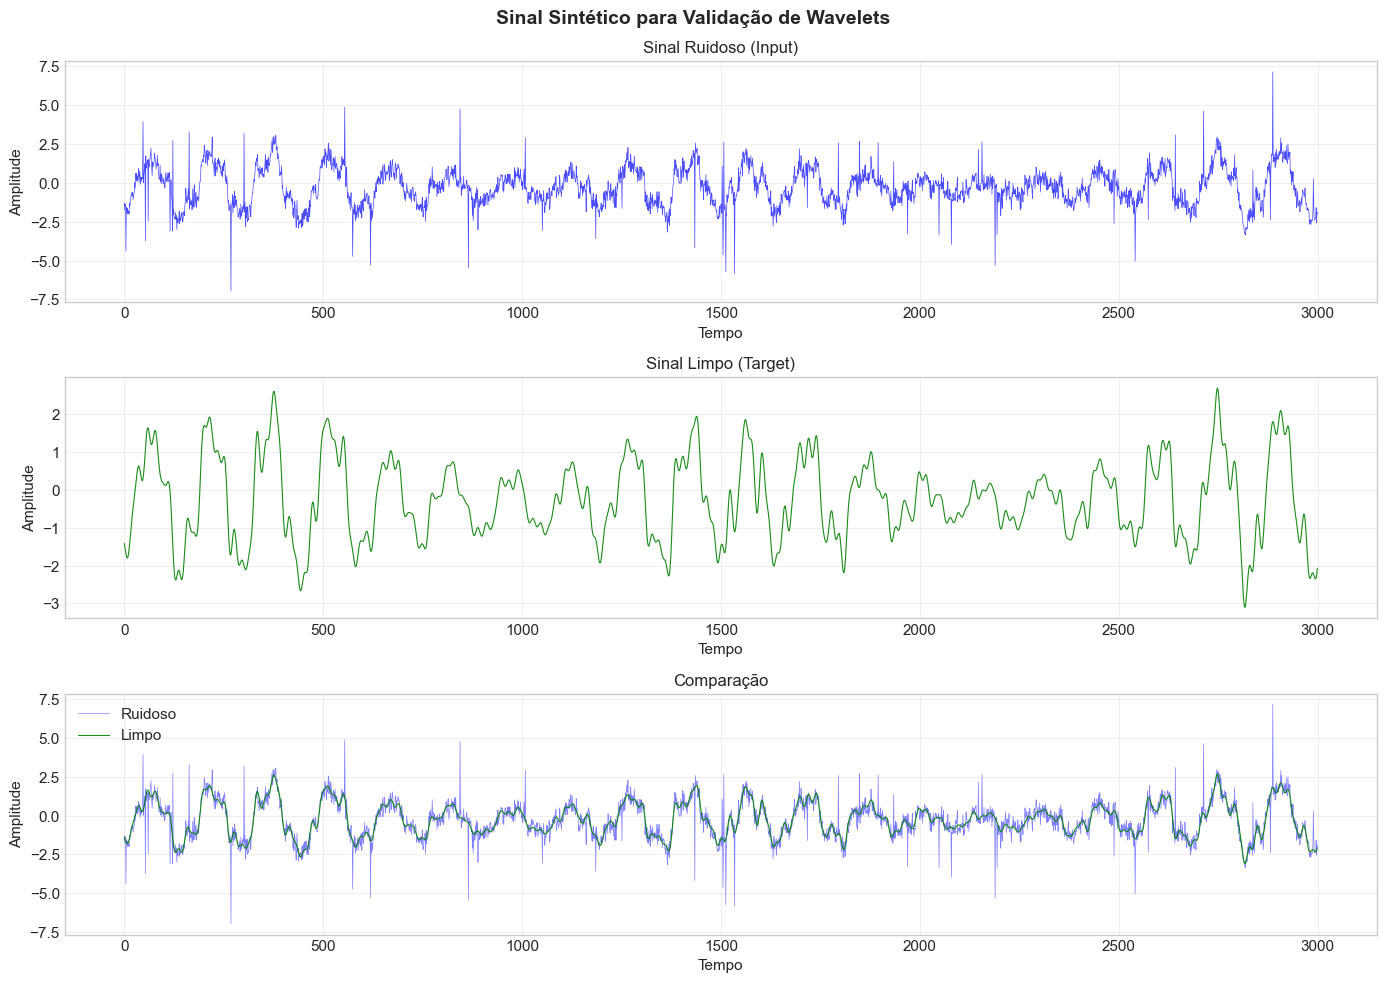

In [ ]:
# Visualizador
visualizer = ExperimentVisualizer()

# Plotar sinal
fig = visualizer.plot_signal(
    noisy_signal, clean_signal,
    title="Sinal Sintético para Validação de Wavelets",
    start=0,
    length=3000
)
plt.show()

### 3.2 Componentes Individuais do Sinal

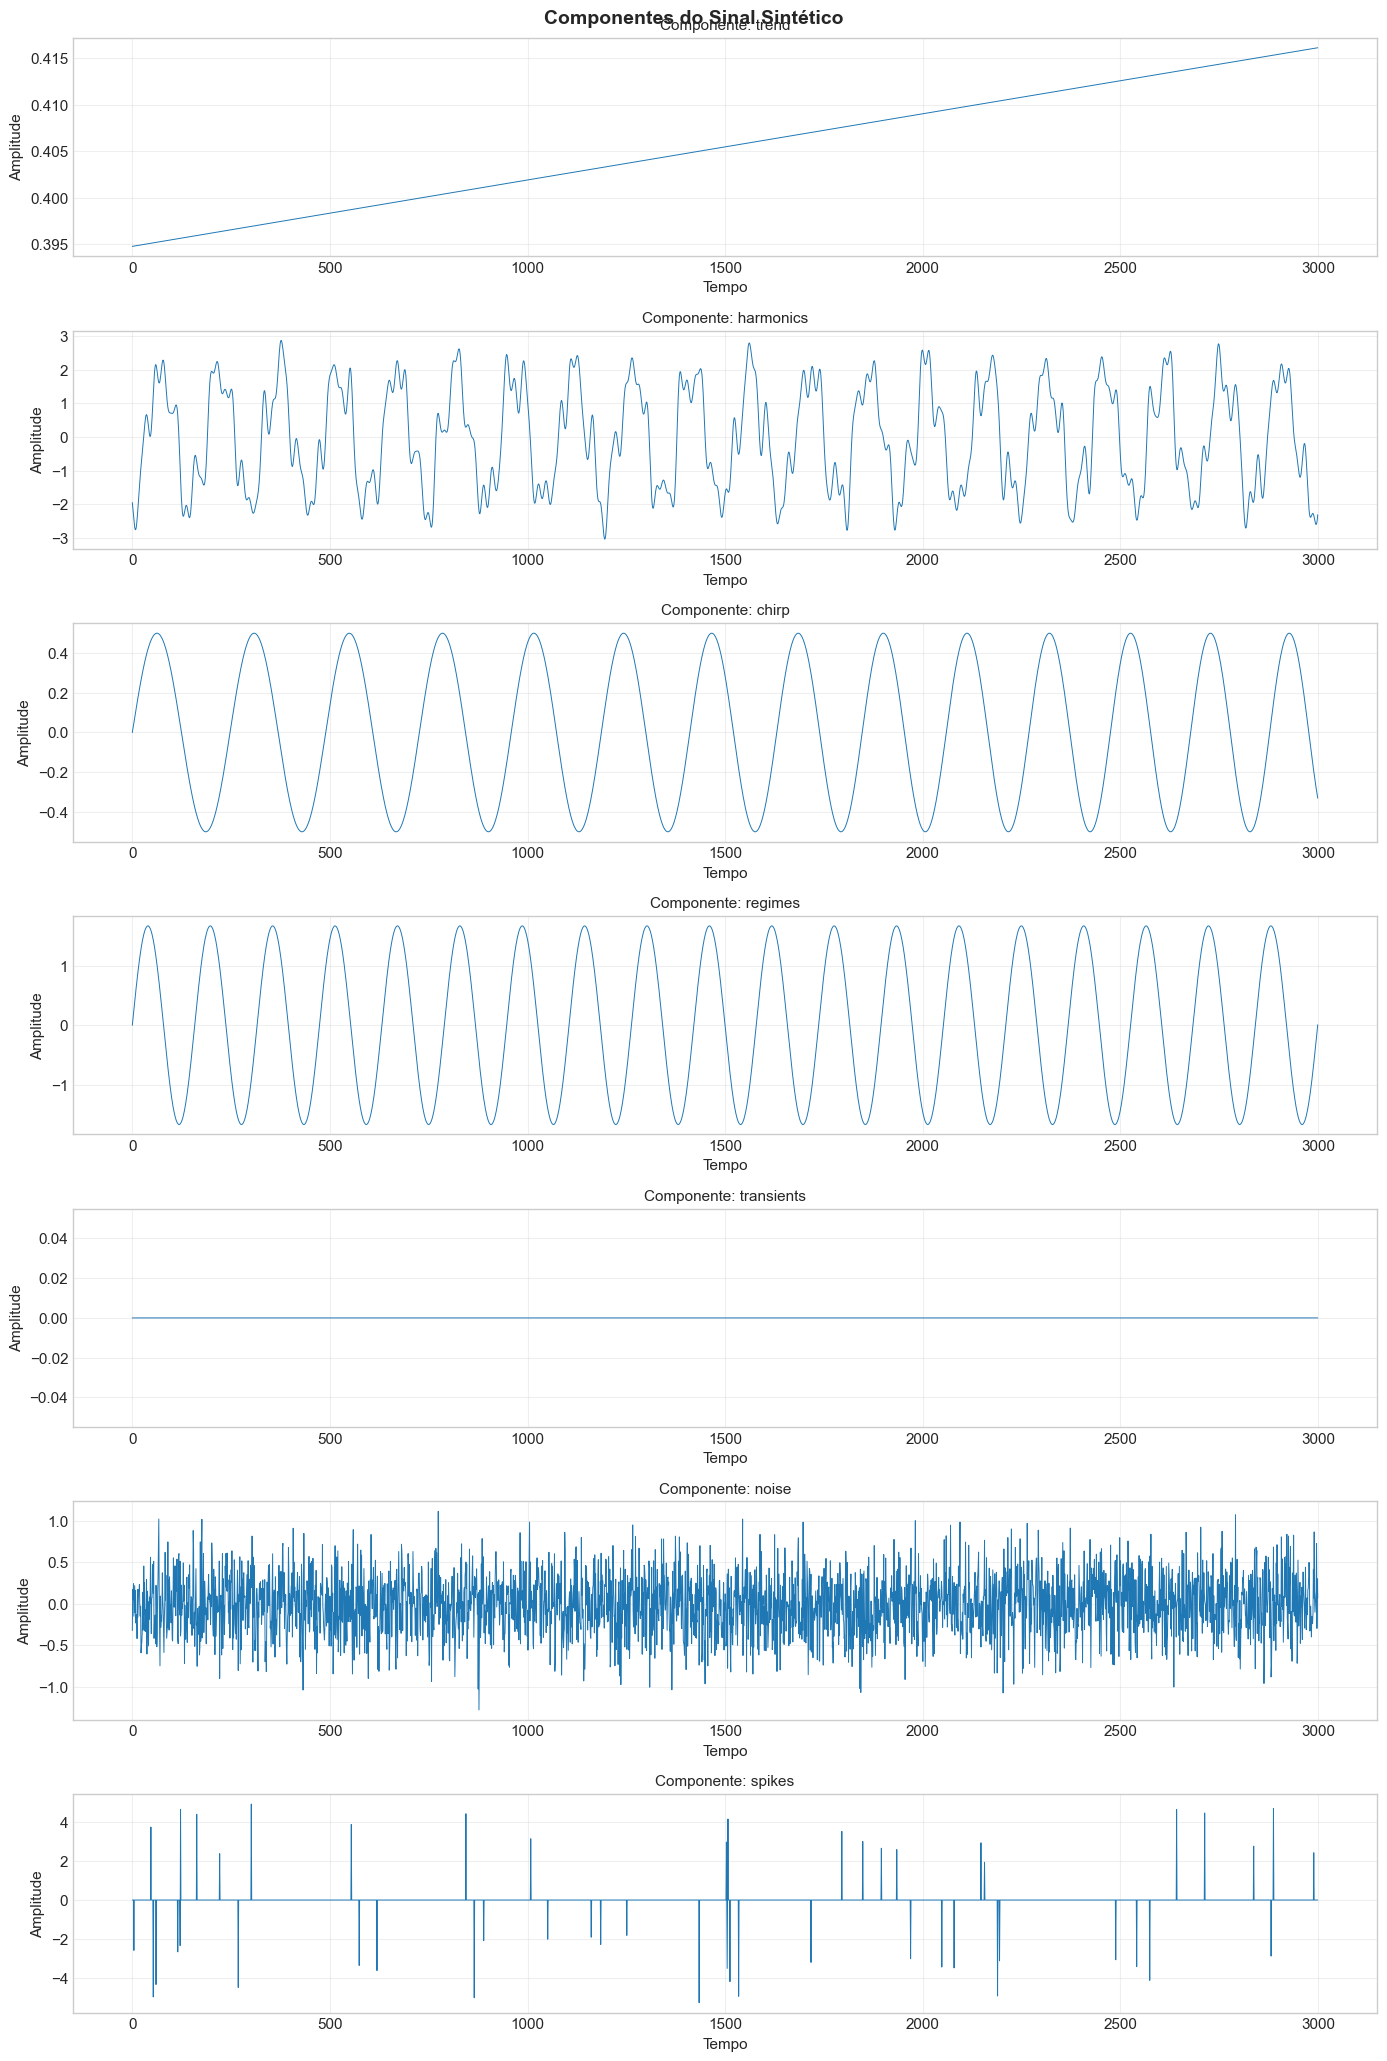

In [ ]:
# Plotar componentes
fig = visualizer.plot_components(
    generator.components,
    length=3000
)
plt.show()

### 3.3 Análise Espectral

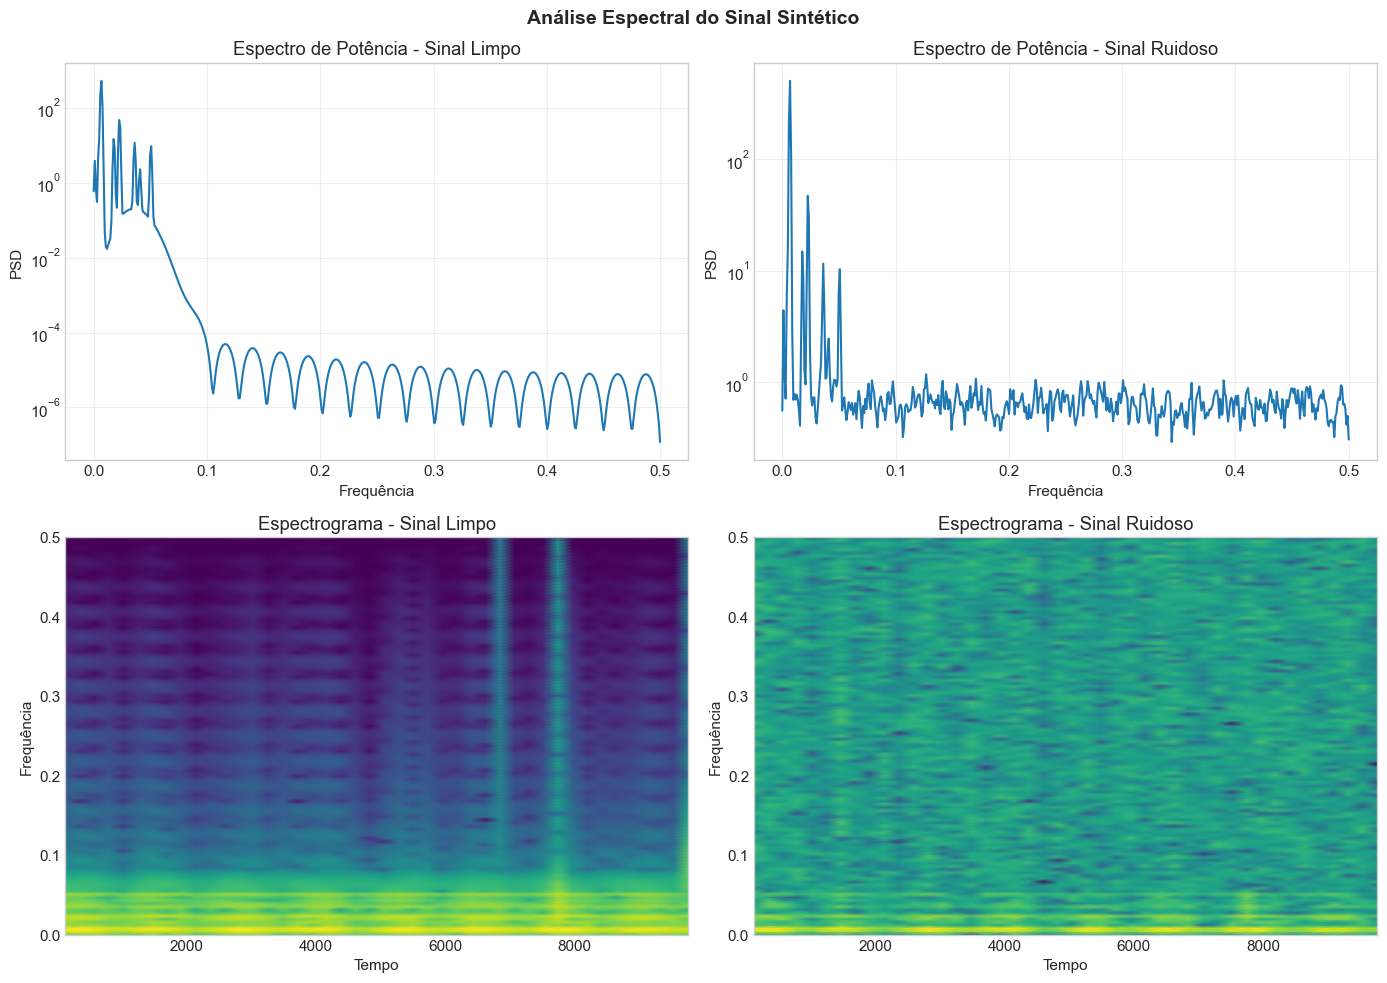

In [ ]:
from scipy import signal as sig

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Espectro de potência - Sinal limpo
freqs_clean, psd_clean = sig.welch(clean_signal[:10000], fs=1.0, nperseg=1024)
axes[0, 0].semilogy(freqs_clean, psd_clean)
axes[0, 0].set_title('Espectro de Potência - Sinal Limpo')
axes[0, 0].set_xlabel('Frequência')
axes[0, 0].set_ylabel('PSD')
axes[0, 0].grid(True, alpha=0.3)

# Espectro de potência - Sinal ruidoso
freqs_noisy, psd_noisy = sig.welch(noisy_signal[:10000], fs=1.0, nperseg=1024)
axes[0, 1].semilogy(freqs_noisy, psd_noisy)
axes[0, 1].set_title('Espectro de Potência - Sinal Ruidoso')
axes[0, 1].set_xlabel('Frequência')
axes[0, 1].set_ylabel('PSD')
axes[0, 1].grid(True, alpha=0.3)

# Espectrograma - Sinal limpo
f, t, Sxx = sig.spectrogram(clean_signal[:10000], fs=1.0, nperseg=256)
axes[1, 0].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
axes[1, 0].set_title('Espectrograma - Sinal Limpo')
axes[1, 0].set_xlabel('Tempo')
axes[1, 0].set_ylabel('Frequência')

# Espectrograma - Sinal ruidoso
f, t, Sxx = sig.spectrogram(noisy_signal[:10000], fs=1.0, nperseg=256)
axes[1, 1].pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud', cmap='viridis')
axes[1, 1].set_title('Espectrograma - Sinal Ruidoso')
axes[1, 1].set_xlabel('Tempo')
axes[1, 1].set_ylabel('Frequência')

plt.suptitle('Análise Espectral do Sinal Sintético', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 3.4 Decomposição Wavelet do Sinal

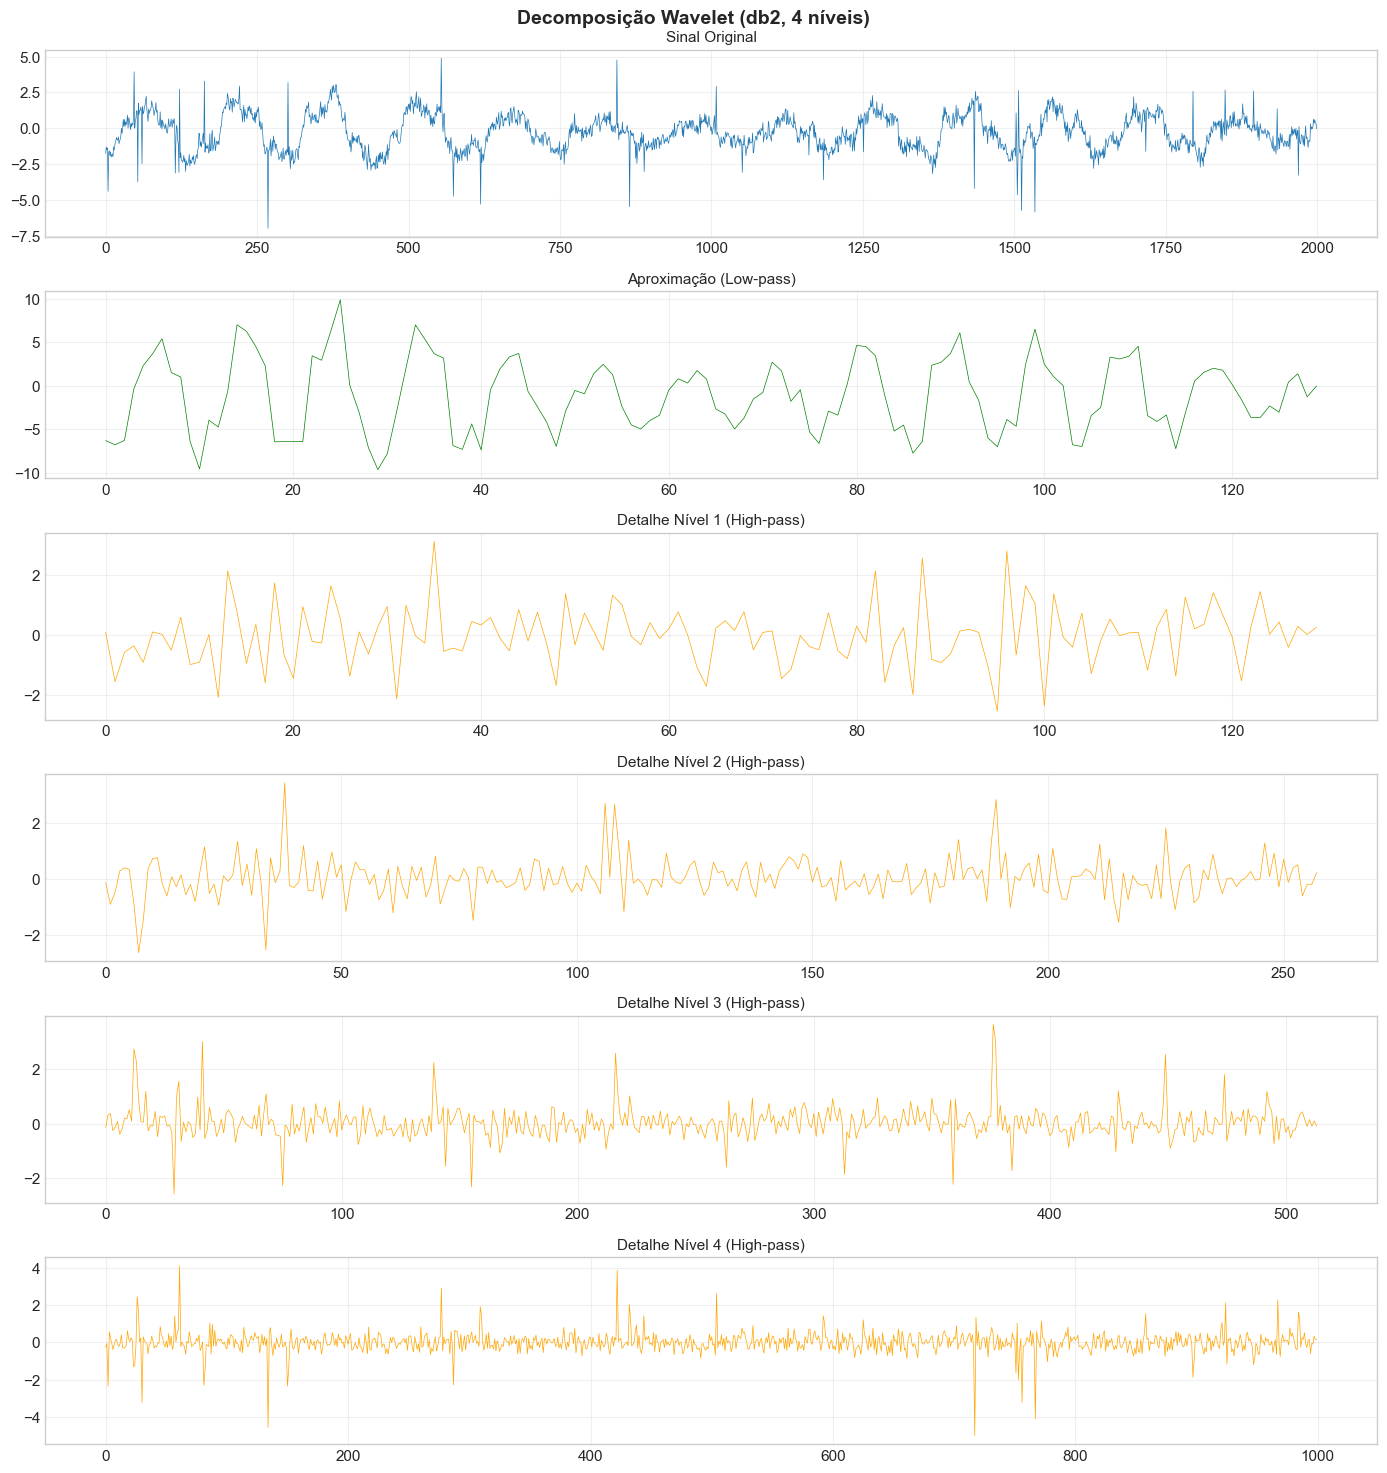


📊 Coeficientes Wavelet:
  Aproximação (A4): 130 coeficientes
  Detalhe D1: 130 coeficientes
  Detalhe D2: 258 coeficientes
  Detalhe D3: 514 coeficientes
  Detalhe D4: 1025 coeficientes


In [ ]:
# Decompor com wavelet db2
wavelet_extractor = WaveletFeatureExtractor(wavelet='db2', level=4)
sample_signal = noisy_signal[:2048]
approx, details = wavelet_extractor.decompose(sample_signal)

# Plotar decomposição
fig = visualizer.plot_wavelet_decomposition(
    sample_signal, approx, details,
    title="Decomposição Wavelet (db2, 4 níveis)"
)
plt.show()

print(f"\n📊 Coeficientes Wavelet:")
print(f"  Aproximação (A4): {len(approx)} coeficientes")
for i, d in enumerate(details):
    print(f"  Detalhe D{i+1}: {len(d)} coeficientes")

## 4. Criação do Dataset para Regressão

O objetivo da tarefa é:
- **Input**: Janela do sinal ruidoso (256 amostras)
- **Output**: Valor do sinal limpo no final da janela (denoise + previsão)

In [ ]:
# Criar dataset para regressão
X, y = generator.create_regression_dataset(
    sequence_length=256,
    horizon=1,      # Prever 1 passo à frente
    stride=1        # Janela deslizante com passo 1
)

print(f"📦 Dataset para Regressão:")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")
print(f"  Número de sequências: {len(X):,}")
print(f"\nMemória:")
print(f"  X: {X.nbytes / 1e6:.2f} MB")
print(f"  y: {y.nbytes / 1e6:.2f} MB")

📦 Dataset para Regressão:
  X shape: (49744, 256)
  y shape: (49744,)
  Número de sequências: 49,744

Memória:
  X: 101.88 MB
  y: 0.40 MB


### 4.1 Visualização de Amostras do Dataset

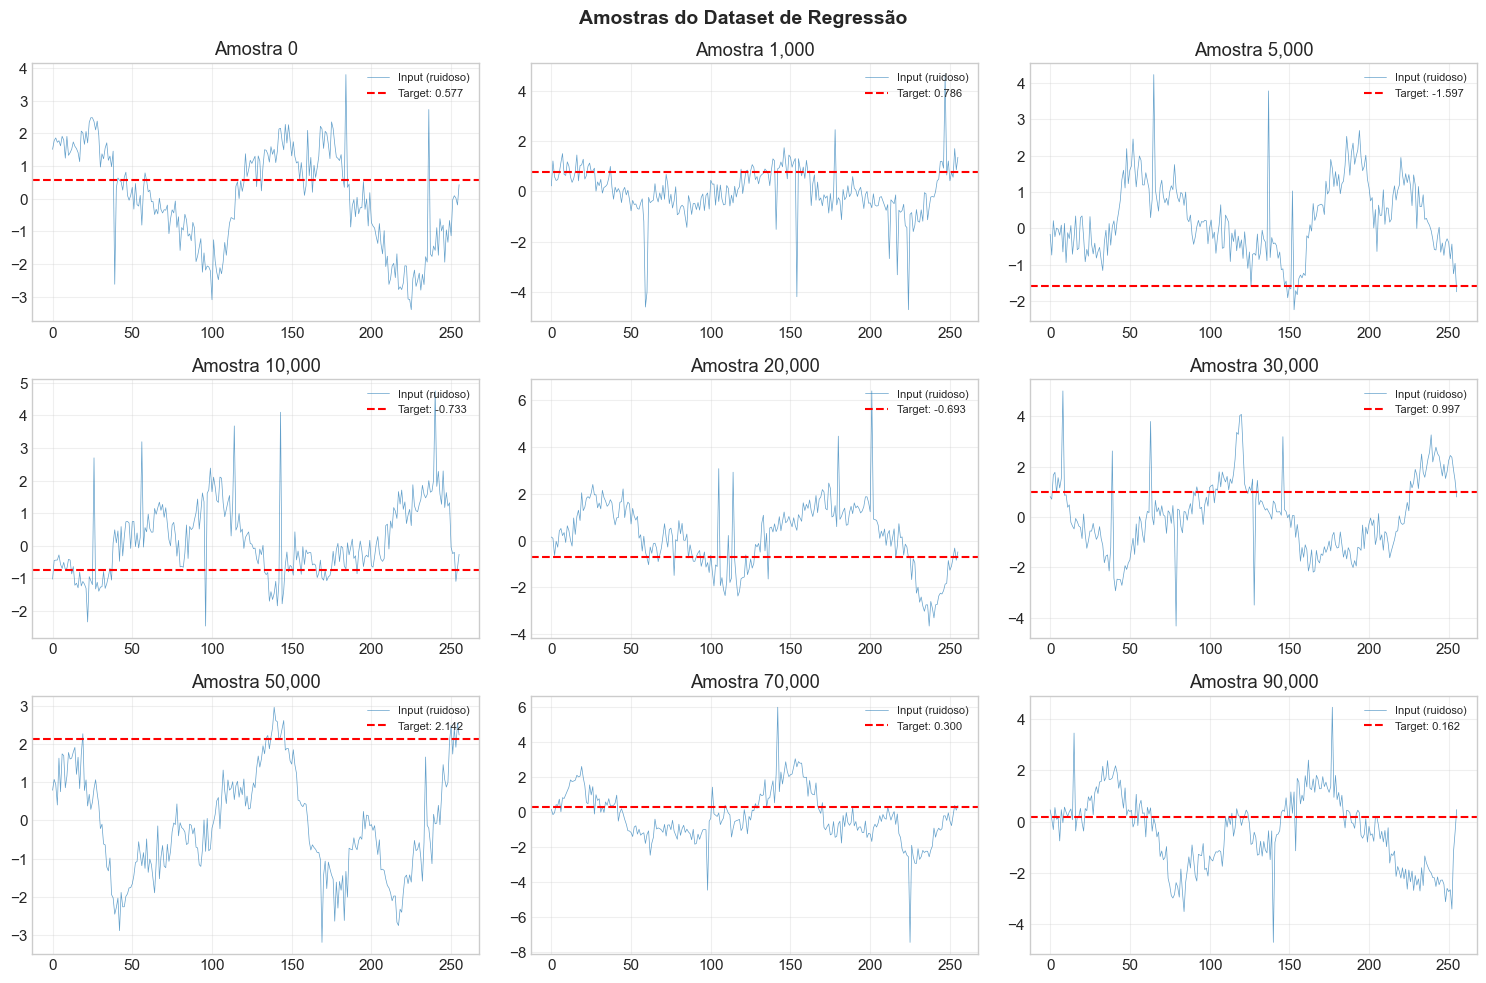

In [ ]:
# Visualizar algumas amostras
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

sample_indices = [0, 1000, 5000, 10000, 20000, 30000, 50000, 70000, 90000]

for idx, (ax, sample_idx) in enumerate(zip(axes.flatten(), sample_indices)):
    if sample_idx < len(X):
        ax.plot(X[sample_idx], alpha=0.7, linewidth=0.5, label='Input (ruidoso)')
        ax.axhline(y=y[sample_idx], color='r', linestyle='--', label=f'Target: {y[sample_idx]:.3f}')
        ax.set_title(f'Amostra {sample_idx:,}')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)

plt.suptitle('Amostras do Dataset de Regressão', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.2 Distribuição dos Targets

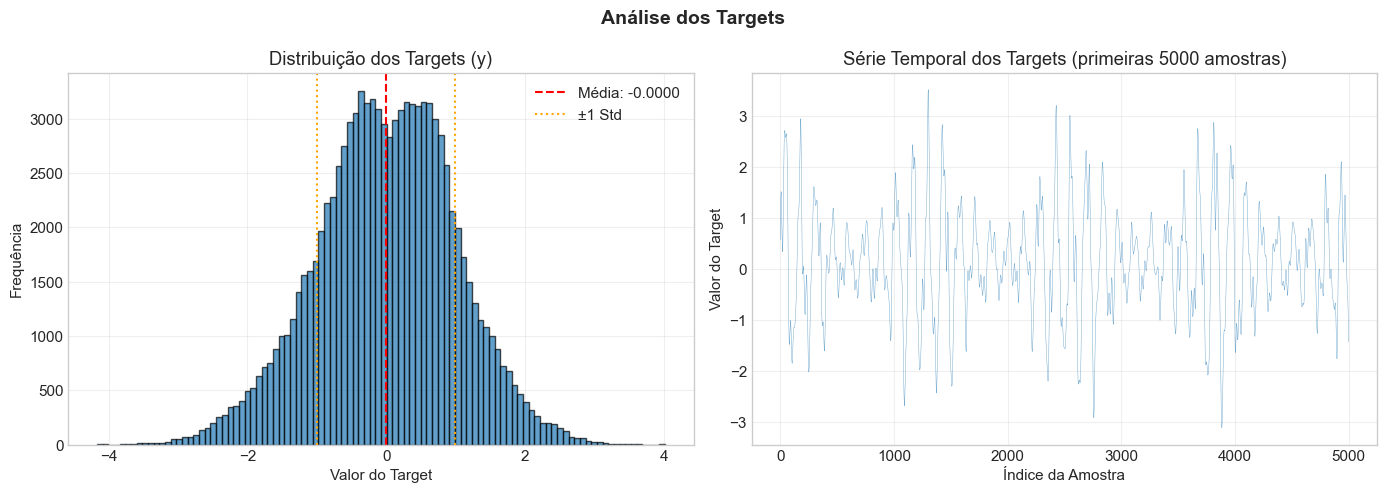


Estatísticas dos Targets:
  Média: -0.000039
  Std: 0.998724
  Min: -4.169545
  Max: 4.019938
  Mediana: 0.020387


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma
axes[0].hist(y, bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(y.mean(), color='r', linestyle='--', label=f'Média: {y.mean():.4f}')
axes[0].axvline(y.mean() - y.std(), color='orange', linestyle=':', label=f'±1 Std')
axes[0].axvline(y.mean() + y.std(), color='orange', linestyle=':')
axes[0].set_xlabel('Valor do Target')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição dos Targets (y)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Série temporal dos targets
axes[1].plot(y[:5000], alpha=0.7, linewidth=0.3)
axes[1].set_xlabel('Índice da Amostra')
axes[1].set_ylabel('Valor do Target')
axes[1].set_title('Série Temporal dos Targets (primeiras 5000 amostras)')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Análise dos Targets', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nEstatísticas dos Targets:")
print(f"  Média: {y.mean():.6f}")
print(f"  Std: {y.std():.6f}")
print(f"  Min: {y.min():.6f}")
print(f"  Max: {y.max():.6f}")
print(f"  Mediana: {np.median(y):.6f}")

## 5. Divisão Train/Val/Test

Para séries temporais, respeitamos a ordem temporal:
- **Train**: 70% (primeiras amostras)
- **Validation**: 15% 
- **Test**: 15% (últimas amostras)

In [ ]:
# Divisão temporal (sem shuffle!)
n_samples = len(X)
train_end = int(0.70 * n_samples)
val_end = int(0.85 * n_samples)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

print(f"📊 Divisão do Dataset:")
print(f"  Train: {len(X_train):,} amostras ({len(X_train)/n_samples*100:.1f}%)")
print(f"  Val:   {len(X_val):,} amostras ({len(X_val)/n_samples*100:.1f}%)")
print(f"  Test:  {len(X_test):,} amostras ({len(X_test)/n_samples*100:.1f}%)")

📊 Divisão do Dataset:
  Train: 34,820 amostras (70.0%)
  Val:   7,462 amostras (15.0%)
  Test:  7,462 amostras (15.0%)


## 6. Salvando o Dataset

In [ ]:
# Criar diretório de dados
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Salvar dataset completo
paths = generator.save(DATA_DIR, X, y, prefix="synthetic_regression")

# Salvar splits
np.save(DATA_DIR / "X_train.npy", X_train)
np.save(DATA_DIR / "y_train.npy", y_train)
np.save(DATA_DIR / "X_val.npy", X_val)
np.save(DATA_DIR / "y_val.npy", y_val)
np.save(DATA_DIR / "X_test.npy", X_test)
np.save(DATA_DIR / "y_test.npy", y_test)

# Salvar sinais brutos
np.save(DATA_DIR / "noisy_signal.npy", noisy_signal)
np.save(DATA_DIR / "clean_signal.npy", clean_signal)

print(f"\n✅ Dataset salvo em: {DATA_DIR}")
print(f"\nArquivos salvos:")
for f in sorted(DATA_DIR.glob("*.npy")):
    size_mb = f.stat().st_size / 1e6
    print(f"  {f.name}: {size_mb:.2f} MB")


✅ Dataset salvo em: /Users/fteodoro/Dropbox/Doutorado/Fontes/LearnableWaveletLayer/tests/synthetic/data

Arquivos salvos:
  X_test.npy: 15.28 MB
  X_train.npy: 71.31 MB
  X_val.npy: 15.28 MB
  clean_signal.npy: 0.40 MB
  noisy_signal.npy: 0.40 MB
  synthetic_regression_X.npy: 101.88 MB
  synthetic_regression_component_chirp.npy: 0.40 MB
  synthetic_regression_component_harmonics.npy: 0.40 MB
  synthetic_regression_component_noise.npy: 0.40 MB
  synthetic_regression_component_regimes.npy: 0.40 MB
  synthetic_regression_component_spikes.npy: 0.40 MB
  synthetic_regression_component_transients.npy: 0.40 MB
  synthetic_regression_component_trend.npy: 0.40 MB
  synthetic_regression_y.npy: 0.40 MB
  y_test.npy: 0.06 MB
  y_train.npy: 0.28 MB
  y_val.npy: 0.06 MB


## 7. Resumo e Próximos Passos

### O que foi gerado:
1. ✅ Sinal sintético com 100k amostras
2. ✅ Características multi-escala ideais para wavelets
3. ✅ Ruído significativo (SNR ~5dB)
4. ✅ Dataset de regressão com ~99k sequências
5. ✅ Divisão Train/Val/Test temporal

### Próximos notebooks:
- `01_ml_experiments.ipynb` - Experimentos ML (SVM, RF, XGBoost, LightGBM)
- `02_dl_raw_experiments.ipynb` - DL com sinal raw (CNN, LSTM, Transformer)
- `03_dl_wavelet_experiments.ipynb` - DL com wavelets fixas (db2)
- `04_learned_wavelet_experiments.ipynb` - DL com LearnedWaveletDWT1D_QMF
- `05_comparison_analysis.ipynb` - Análise comparativa final

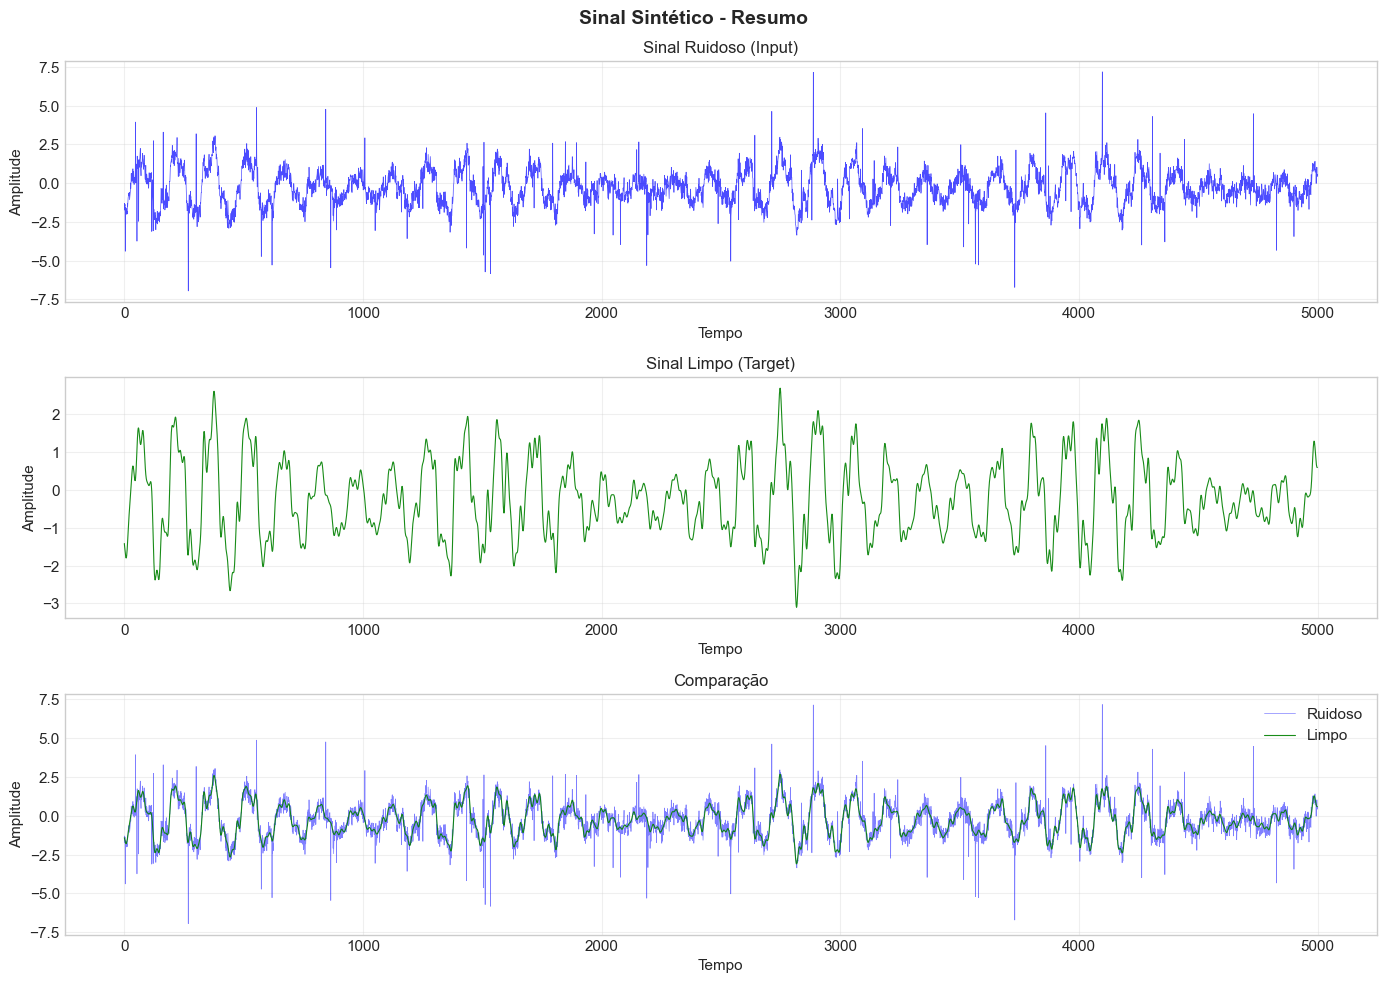


🎉 Notebook concluído com sucesso!

Dataset pronto para experimentos de ML e Deep Learning.


In [ ]:
# Salvar figura resumo
fig = visualizer.plot_signal(
    noisy_signal, clean_signal,
    title="Sinal Sintético - Resumo",
    start=0,
    length=5000,
    save_path=DATA_DIR / "signal_overview.png"
)
plt.show()

print(f"\n🎉 Notebook concluído com sucesso!")
print(f"\nDataset pronto para experimentos de ML e Deep Learning.")